In [50]:
import pickle
import pandas as pd
import numpy as np
import cv2

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50

from livelossplot import PlotLossesKeras

np.random.seed(0)


In [52]:

data_dir = r"C:\Base_Camp\Pliki\archive"
train_dir = r"C:\Base_Camp\Pliki\archive\train"
test_dir = r"C:\Base_Camp\Pliki\archive\test"


In [54]:
datagen = ImageDataGenerator(rescale=1.0/255.0, validation_split=0.2)

train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(48, 48),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

validation_generator = datagen.flow_from_directory(
    test_dir,
    target_size=(48, 48),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

num_classes = len(train_generator.class_indices)
print(f"Number of classes: {num_classes}")


Found 22968 images belonging to 7 classes.
Found 1432 images belonging to 7 classes.
Number of classes: 7


In [56]:
print(f"Train class indices: {train_generator.class_indices}")
print(f"Validation class indices: {validation_generator.class_indices}")

Train class indices: {'angry': 0, 'disgusted': 1, 'fearful': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprised': 6}
Validation class indices: {'angry': 0, 'disgusted': 1, 'fearful': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprised': 6}


In [58]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(48, 48, 3))

In [60]:

for layer in base_model.layers:
    layer.trainable = False

num_layers_to_unfreeze = 7
conv_layers = [layer for layer in base_model.layers if isinstance(layer, Conv2D)]

for layer in conv_layers[-num_layers_to_unfreeze:]:
    layer.trainable = True

model = Sequential([
    base_model,
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(num_classes, activation='softmax')
])

optimizer = Adam(0.001, decay=0.0005)

model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])


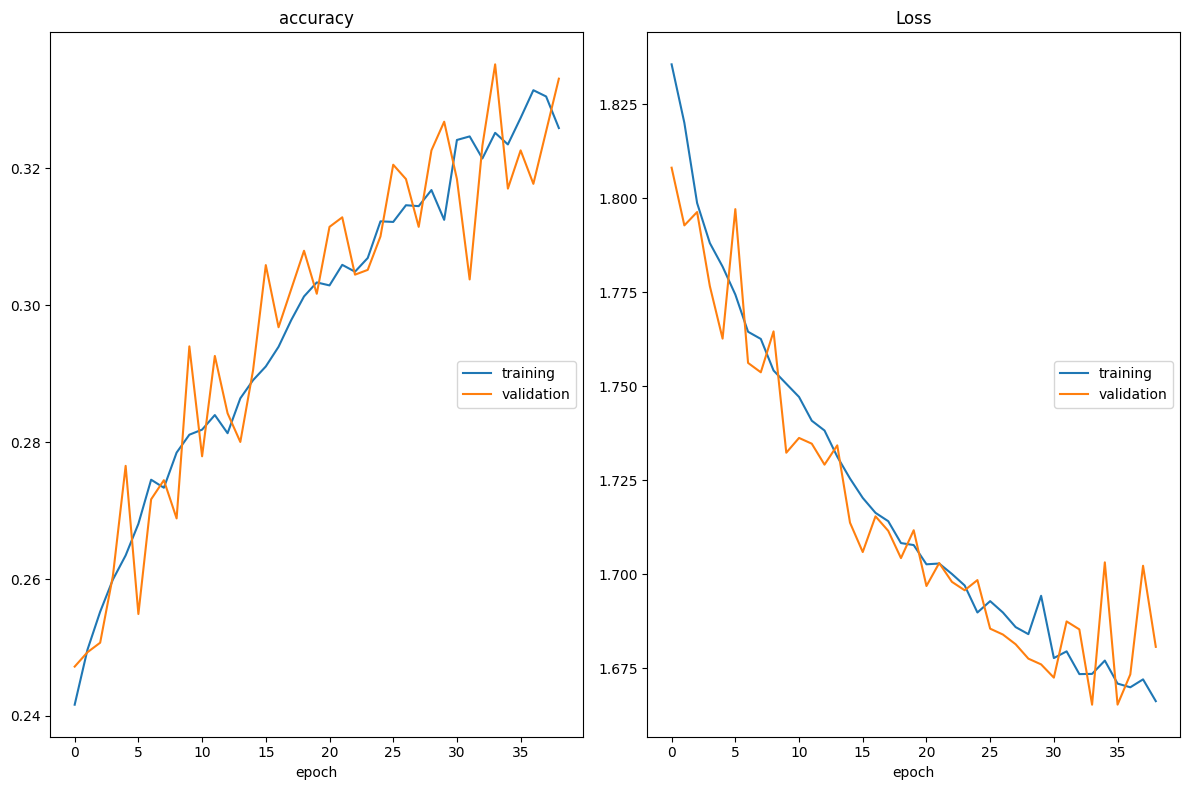

accuracy
	training         	 (min:    0.242, max:    0.331, cur:    0.326)
	validation       	 (min:    0.247, max:    0.335, cur:    0.333)
Loss
	training         	 (min:    1.666, max:    1.836, cur:    1.666)
	validation       	 (min:    1.665, max:    1.808, cur:    1.681)

Epoch 39: val_loss did not improve from 1.66526
718/718 ━━━━━━━━━━━━━━━━━━━━ 117s 162ms/step - accuracy: 0.3265 - loss: 1.6624 - val_accuracy: 0.3331 - val_loss: 1.6807 - learning_rate: 0.0010
Epoch 39: early stopping


In [62]:

callbacks = [
    PlotLossesKeras(),
    EarlyStopping(monitor='val_loss', patience=5, verbose=1),
    
    ModelCheckpoint(filepath= 'C:\Base_Camp\Pliki\models\emotion_model_ResNet50_model_{epoch:02d}_{val_loss:.2f}.keras', 
                    monitor='val_loss', save_best_only=True, mode='min' , verbose=1),
    ReduceLROnPlateau( monitor='val_loss', factor=0.1, patience=10, verbose=1, mode='auto', min_lr=1e-6 ) 
]

with tf.device('/GPU:0'):
    history = model.fit(
        train_generator,
        epochs=50,
        callbacks=callbacks,
        validation_data=validation_generator
    )


In [30]:
test_generator = datagen.flow_from_directory(
    test_dir,
    target_size=(48, 48),
    batch_size=32,
    class_mode='categorical'
)

loss, accuracy = model.evaluate(test_generator, verbose=1)

print(f'Test Loss: {loss}')
print(f'Test Accuracy: {accuracy}')

Found 7178 images belonging to 7 classes.
225/225 ━━━━━━━━━━━━━━━━━━━━ 32s 141ms/step - accuracy: 0.3311 - loss: 1.6693
Test Loss: 1.6606510877609253
Test Accuracy: 0.3328225016593933


In [25]:
model.save(r'C:\Base_Camp\Pliki\emotion_model_resNet50.h5')

In [9]:
model = load_model(r"C:\Base_Camp\Pliki\models\emotion_model_ResNet50_model_20_1.58.keras")

AttributeError: Exception encountered when calling Flatten.call().

[1m'list' object has no attribute 'shape'[0m

Arguments received by Flatten.call():
  • args=(['<KerasTensor shape=(None, 2, 2, 2048), dtype=float32, sparse=False, name=keras_tensor_731>'],)
  • kwargs=<class 'inspect._empty'>

In [64]:


emotion_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

def predict_emotion(face_image, model):
    face_image = cv2.resize(face_image, (48, 48))
    face_image = cv2.cvtColor(face_image, cv2.COLOR_GRAY2RGB)  
    face_image = face_image / 255.0
    face_image = np.expand_dims(face_image, 0) 
    predictions = model.predict(face_image)
    return emotion_labels[np.argmax(predictions)]

cap = cv2.VideoCapture(0)

while True:
    ret, frame = cap.read()
    if not ret:
        break

    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.3, minNeighbors=5)

    for (x, y, w, h) in faces:
        face = gray[y:y+h, x:x+w]
        emotion = predict_emotion(face, model)
        
        cv2.rectangle(frame, (x, y), (x+w, y+h), (255, 0, 0), 2)
        cv2.putText(frame, emotion, (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 0, 0), 2)

    cv2.imshow('Emotion Recognition', frame)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━